In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split,cross_val_score,KFold

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"Datos Completos\Octubre-Abril.csv", sep= "\t", parse_dates=["PoC AB12"], dayfirst=True)
df.columns = ["Date","Pax"]
df = df.iloc[4:,:].reset_index(False)
df = df.drop("index", axis=1)

df["Date"] = pd.to_datetime(df["Date"],  format="%d-%m-%Y %H:%M:%S")
df["Pax"] = pd.to_numeric(df["Pax"])

df["month"] = df["Date"].dt.month
df["month"] = df["Date"].dt.month
df["Hour"] = df["Date"].dt.hour
df["Day"] = df["Date"].dt.day
df["Year"] = df["Date"].dt.year
df

df = df.groupby(["Hour","month","Day","Year"])[["Pax"]].max().reset_index()

""" eliminamos cualquier detección fuerea de las horas laborales de la oficina"""

df.loc[df['Hour'] == 0, 'Pax'] = 0
df.loc[df['Hour'] == 1, 'Pax'] = 0
df.loc[df['Hour'] == 2, 'Pax'] = 0
df.loc[df['Hour'] == 3, 'Pax'] = 0
df.loc[df['Hour'] == 4, 'Pax'] = 0
df.loc[df['Hour'] == 5, 'Pax'] = 0
df.loc[df['Hour'] == 6, 'Pax'] = 0
df.loc[df['Hour'] == 20, 'Pax'] = 0
df.loc[df['Hour'] == 21, 'Pax'] = 0
df.loc[df['Hour'] == 22, 'Pax'] = 0
df.loc[df['Hour'] == 23, 'Pax'] = 0

""" separación de datos por meses"""

df4 = df.loc[df.loc[:,"month"]==4]
df3 = df.loc[df.loc[:,"month"]==3]
df2 = df.loc[df.loc[:,"month"]==2]
df1 = df.loc[df.loc[:,"month"]==1]
df12 = df.loc[df.loc[:,"month"]==12]
df11 = df.loc[df.loc[:,"month"]==11]
df10 = df.loc[df.loc[:,"month"]==10]

""" inclusión de columna fecha con horas limpias"""

df41 = df4.drop("Pax", axis=1)
df31 = df3.drop("Pax", axis=1)
df21 = df2.drop("Pax", axis=1)
df01 = df1.drop("Pax", axis=1)
df121 = df12.drop("Pax", axis=1)
df111 = df11.drop("Pax", axis=1)
df101 = df10.drop("Pax", axis=1)

df41["Year","month","Day"] = pd.to_datetime(df41)
df31["Year","month","Day"] = pd.to_datetime(df31)
df21["Year","month","Day"] = pd.to_datetime(df21)
df01["Year","month","Day"] = pd.to_datetime(df01)
df121["Year","month","Day"] = pd.to_datetime(df121)
df111["Year","month","Day"] = pd.to_datetime(df111)
df101["Year","month","Day"] = pd.to_datetime(df101)

df4["Fecha"] = df41.iloc[:,4]
df3["Fecha"] = df31.iloc[:,4]
df2["Fecha"] = df21.iloc[:,4]
df1["Fecha"] = df01.iloc[:,4]
df12["Fecha"] = df121.iloc[:,4]
df11["Fecha"] = df111.iloc[:,4]
df10["Fecha"] = df101.iloc[:,4]

In [6]:
df.corr()

,Hour,month,Day,Year,Pax
Hour,1.000000,-0.000743,-0.036658,0.001172,0.100614
month,-0.000743,1.000000,0.047892,-0.971240,-0.041721
Day,-0.036658,0.047892,1.000000,-0.046309,-0.024818
Year,0.001172,-0.971240,-0.046309,1.000000,0.041585
Pax,0.100614,-0.041721,-0.024818,0.041585,1.000000


<Axes: >

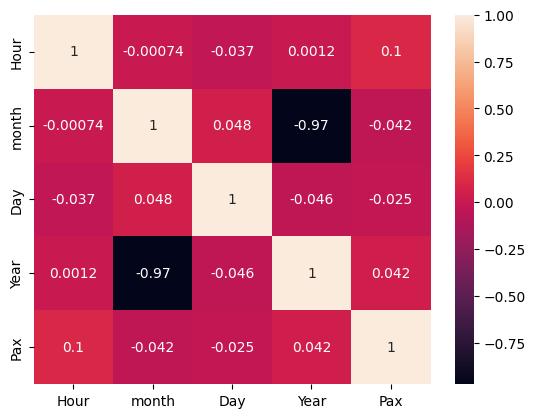

In [8]:
sns.heatmap(df.corr(), annot =True) 

In [51]:
X_train,X_test,y_train,y_test = train_test_split(df.drop("Pax",axis=1),df["Pax"],test_size=0.2,random_state=0)

In [52]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(2833, 4)
(709, 4)
(2833,)
(709,)


In [96]:
xgb = XGBRegressor(max_depth=6,
                   cv = 10,
                   n_jobs = -1,
                   random_state = 0)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, cv=10, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [97]:
predictions = xgb.predict(X_test)

In [98]:
print("mean_squared_error:", mean_squared_error(y_test, predictions))
print("r2_score:", r2_score(y_test, predictions))


mean_squared_error: 0.3048541132443863
r2_score: 0.6513496721547237


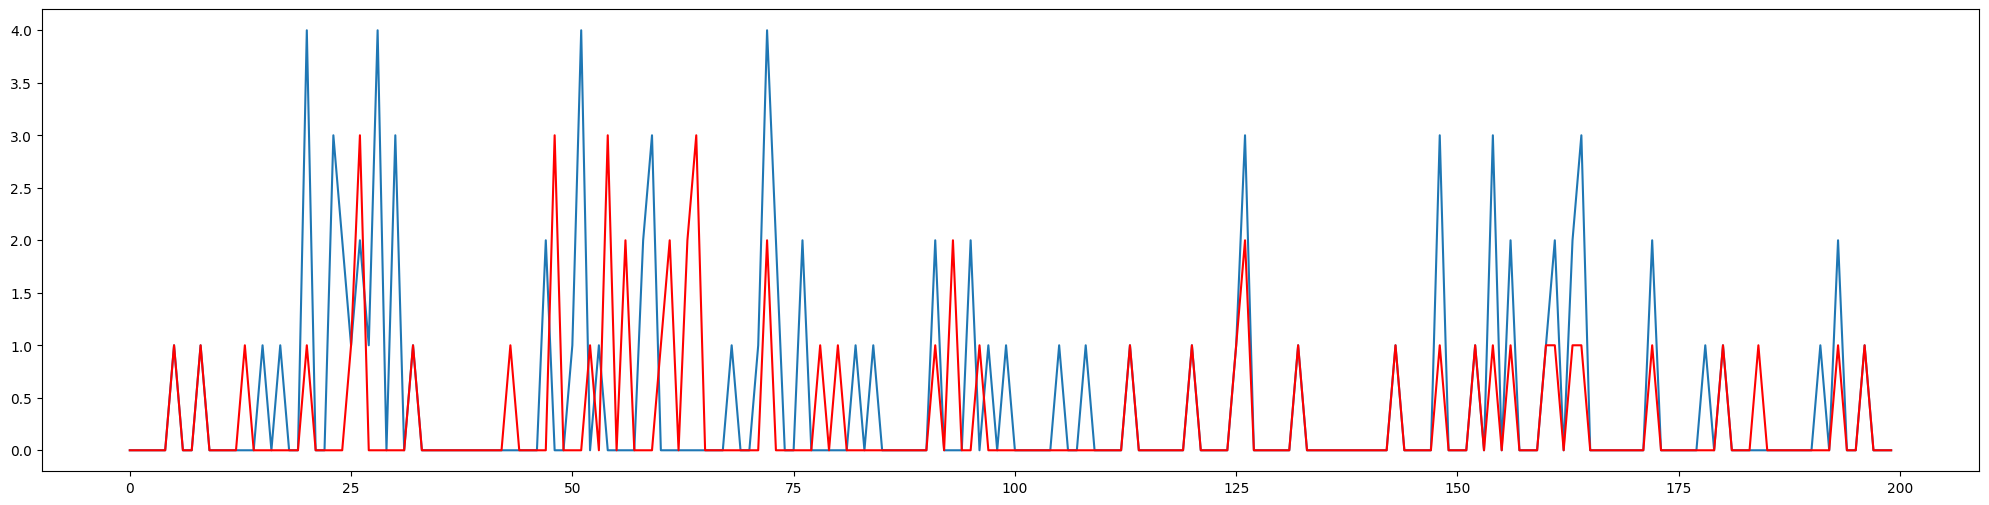

In [91]:
plt.figure(figsize=(25,6))
plt.plot(y_train.tolist()[0:100] + y_test.tolist()[0:100] )
plt.plot(y_test.tolist()[0:100] + xgb.predict(X_test).astype(int).tolist()[0:100] ,color='red');

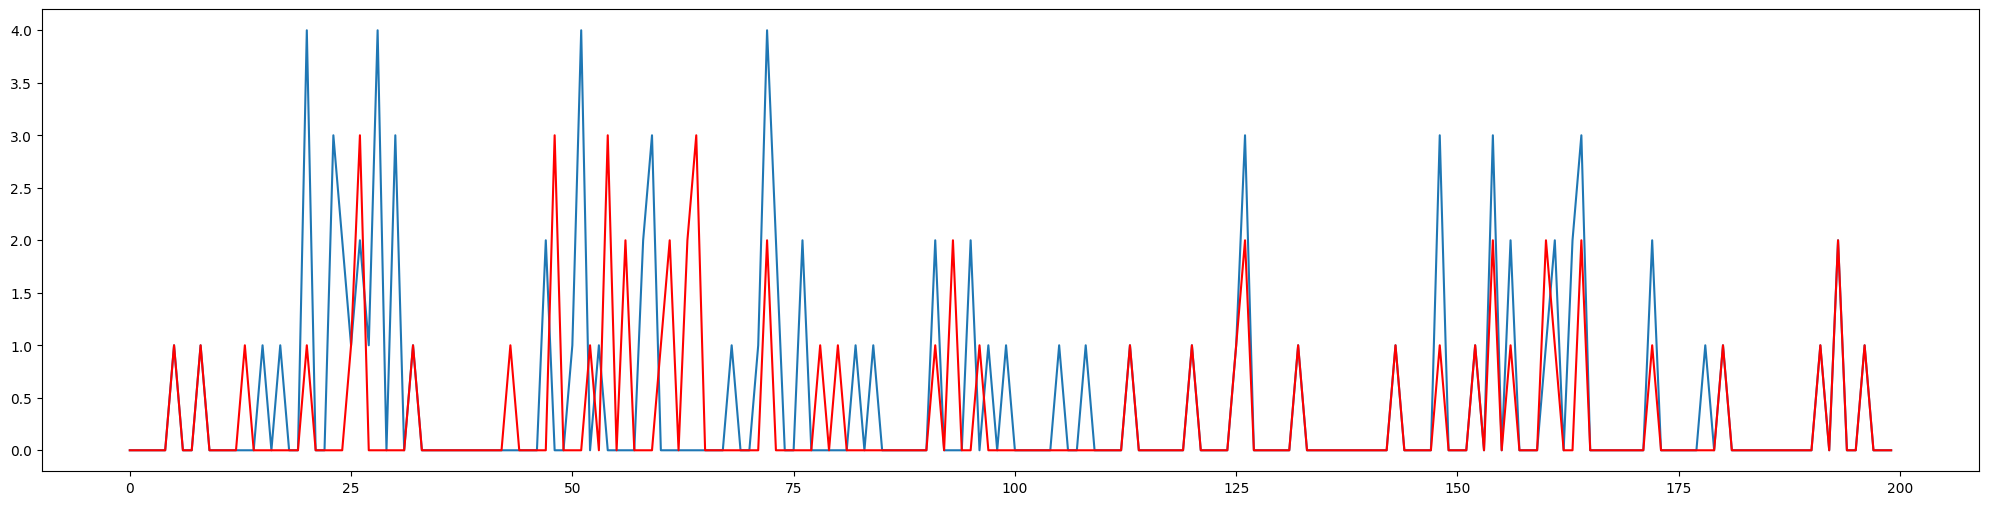

In [79]:
plt.figure(figsize=(25,6))
plt.plot(y_train.tolist()[0:100] + y_test.tolist()[0:100] )
plt.plot(y_test.tolist()[0:100] + xgb.predict(X_test).astype(int).tolist()[0:100] ,color='red');

In [84]:
print("mean_squared_error:", mean_squared_error(y_test, predictions))
print("r2_score:", r2_score(y_test, predictions))

mean_squared_error: 0.3048541132443863
r2_score: 0.6513496721547237
